<a href="https://colab.research.google.com/github/manor-s/DS-course-project-4/blob/main/Classification_project_Olga_Manor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, classification_report, f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, precision_recall_curve

import xgboost as xgb
from xgboost import XGBClassifier


# Load data and explore (EDA)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
csv_file_path = '/content/drive/My Drive/e-commerce project/Churn_Modelling.csv'
churn = pd.read_csv(csv_file_path)



In [4]:
churn.shape

(10000, 14)

In [5]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Label Description

**RowNumber** - Serial Row Number (from 1 to 10000)

**CustomerId** - Unique Ids for bank customer identification

**Surname** - Customer's last name (2932 unique values)

**CreditScore** - Credit score of the customer

**Geography** - The country from which the customer belongs

**Gender** - Male or Female

**Age** - Age of the customer

**Tenure** - Number of years for which the customer has been with the bank

**Balance** - Bank balance of the customer

**NumOfProducts** - Number of bank products the customer is utilising

**HasCrCard** - Binary Flag for whether the customer holds a credit card with the bank or not

**IsActiveMember** - Binary Flag for whether the customer is an active member with the bank or not

**EstimatedSalary** - Estimated salary of the customer in Dollars

**Exited** - Binary flag 1 if the customer closed account with bank and 0 if the customer is retained



In [6]:
churn.CustomerId.nunique(),churn.RowNumber.nunique(),churn.Surname.nunique()

# row number isn't relevant

(10000, 10000, 2932)

In [7]:
churn.drop(columns=["RowNumber"], inplace=True)

In [8]:
churn_no_duplicates = churn.drop_duplicates()
churn_no_duplicates.shape

# no duplicates in dataset

(10000, 13)

In [9]:
churn.isnull().sum()

# no missing values

,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0


In [10]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [11]:
churn.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0


# Distribution of churn label

In [12]:
pd.value_counts(churn['Exited'], normalize=True)

<ipython-input-12-33971958e4c3>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(churn['Exited'], normalize=True)


,proportion
Exited,
0,0.7963
1,0.2037


# Numerical variables

## non binary variables

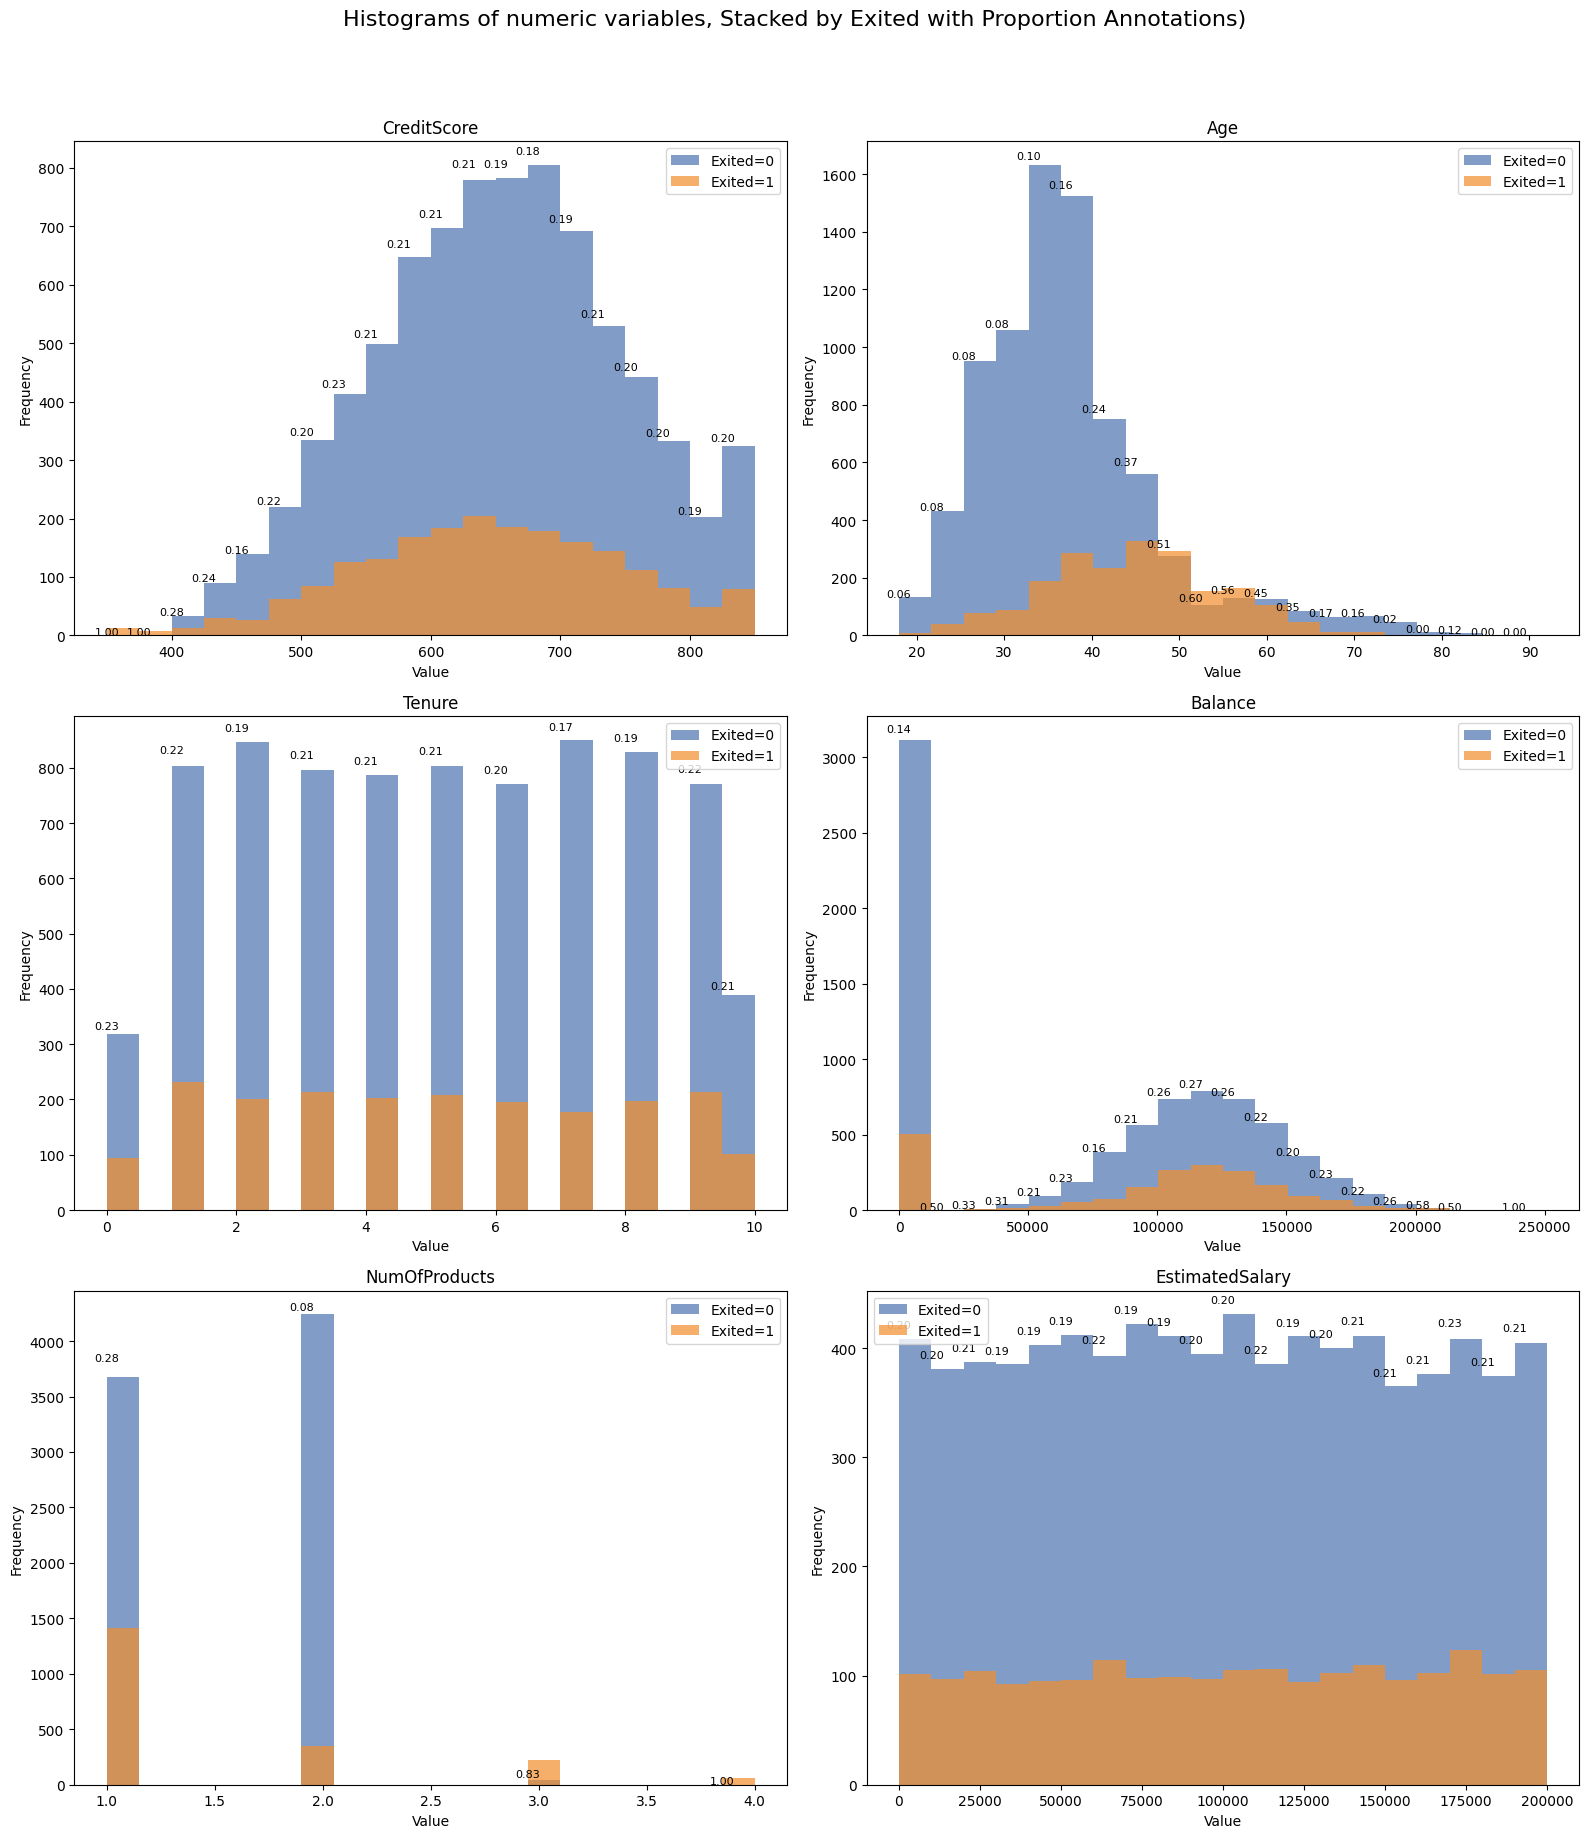

In [13]:
# Set number of columns and dynamic rows for subplots based on columns starting from the 4th column
n_cols = 2  # Customize as needed (number of columns of subplots)
n_rows = int(np.ceil((len(churn.columns) - 3) / n_cols))  # Adjust row calculation to include "exited" and start from 4th column

# Adjust figure size to accommodate all subplots
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))
ax = ax.flatten()  # Flatten the axis array to easily iterate over

relevant_columns = churn.select_dtypes(include=['number']).columns[1:]
#exclude binary variables
numeric_columns = [col for col in relevant_columns if not set(churn[col].unique()).issubset({0, 1})]


# Loop through columns starting from the 4th column
for i, col in enumerate(numeric_columns):  # Start from the 3rd column, including "exited"
  if np.issubdtype(churn[col].dtype, np.number):  # Numeric columns
    bins = 20
    bin_edges = np.histogram_bin_edges(churn[col], bins=bins)

    # Histograms for exited = 0 and exited = 1
    counts_0, _ = np.histogram(churn[churn["Exited"] == 0][col], bins=bin_edges)
    counts_1, _ = np.histogram(churn[churn["Exited"] == 1][col], bins=bin_edges)

    # Plot histograms
    ax[i].hist(bin_edges[:-1], bin_edges, weights=counts_0, color='#4c72b0', alpha=0.7, label='Exited=0')
    ax[i].hist(bin_edges[:-1], bin_edges, weights=counts_1, color='#f28e2b', alpha=0.7, label='Exited=1')

    # Calculate and annotate proportions
    total_counts = counts_0 + counts_1
    proportions = np.divide(counts_1, total_counts, out=np.zeros_like(counts_1, dtype=float), where=total_counts != 0)

    for j in range(len(bin_edges) - 1):
      if total_counts[j] > 0:
        ax[i].text(bin_edges[j], counts_0[j] + counts_1[j] * 0.1, f"{proportions[j]:.2f}",
                   ha='center', color='black', fontsize=8)

    ax[i].set_title(col)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Value')
    ax[i].legend()

# Remove empty subplots if there are any
for j in range(i + 1, len(ax)):
  fig.delaxes(ax[j])

# Add a super title for the entire figure
plt.suptitle('Histograms of numeric variables, Stacked by Exited with Proportion Annotations)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout so the title fits
plt.show()


## Binary variables

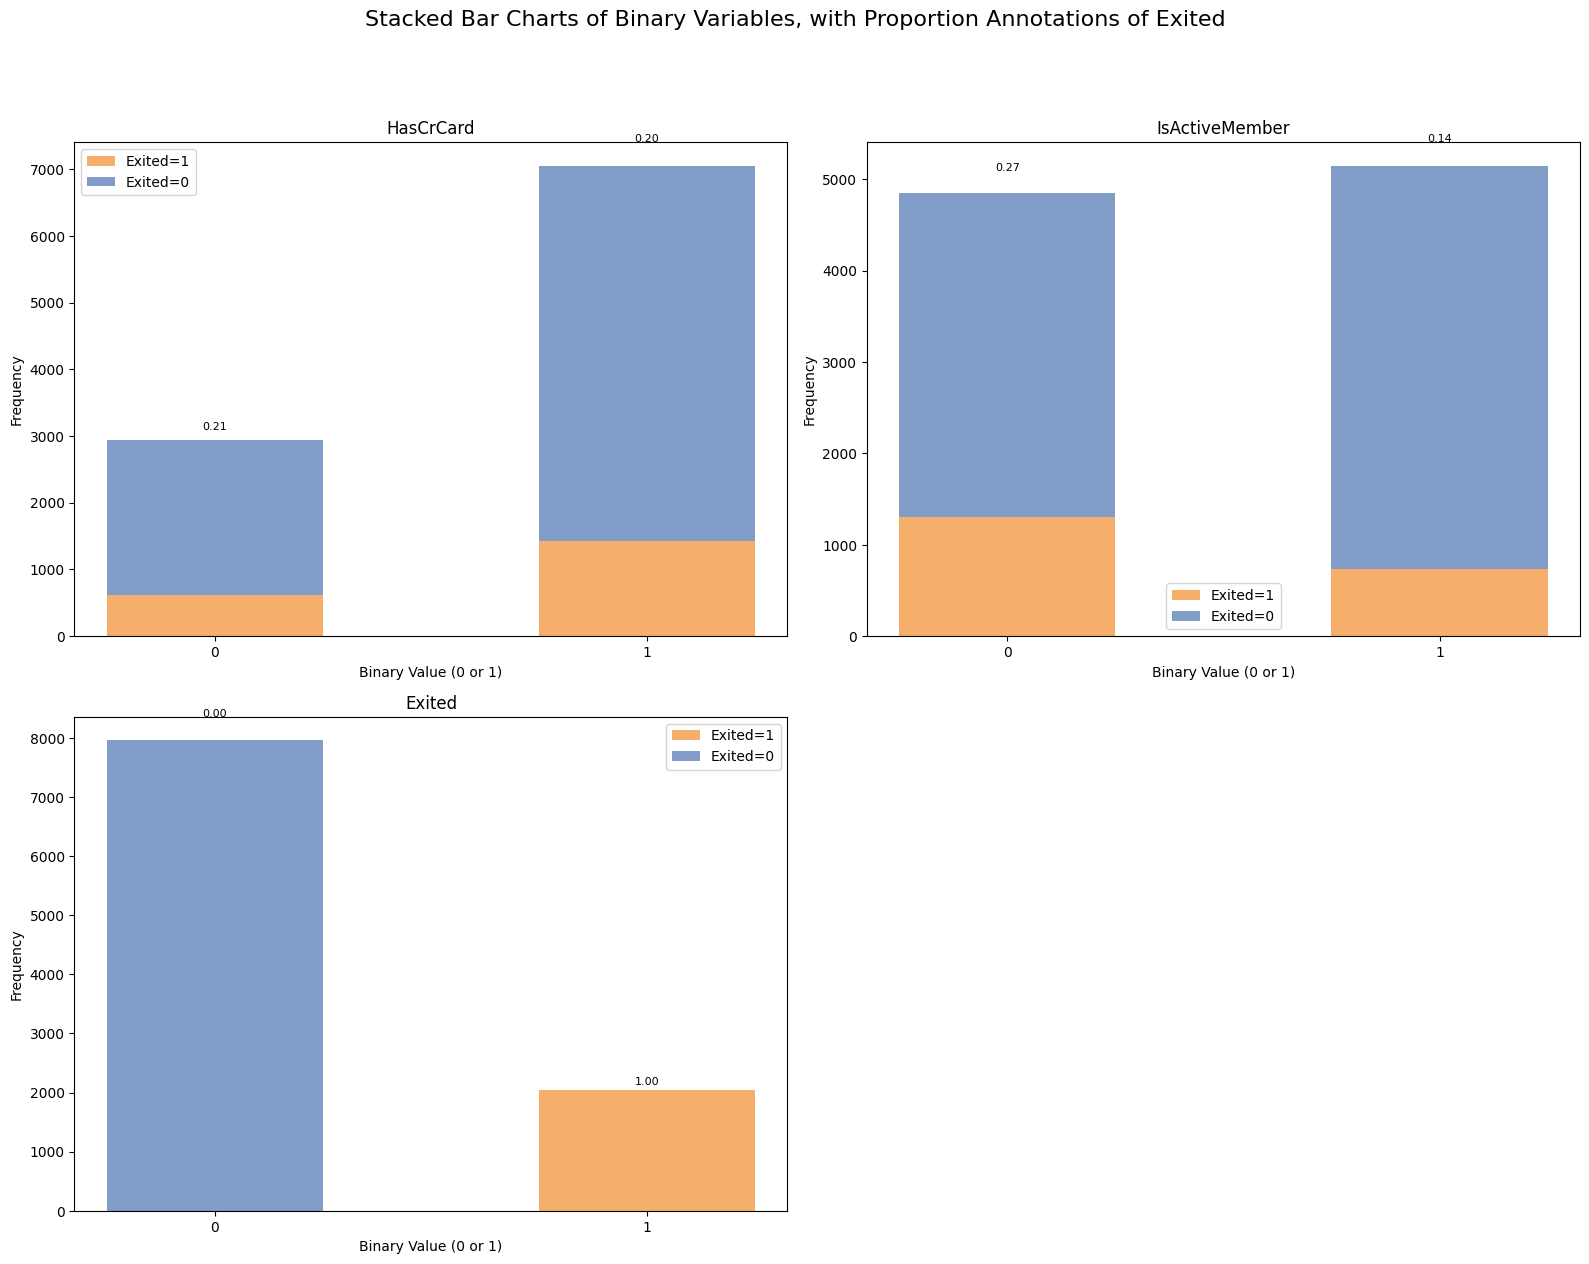

In [14]:
# Set number of columns and dynamic rows for subplots based on columns starting from the 4th column
n_cols = 2  # Customize as needed (number of columns of subplots)
n_rows = int(np.ceil((len(churn.columns) - 3) / n_cols))  # Adjust row calculation to include "exited" and start from 4th column

# Adjust figure size to accommodate all subplots
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))
ax = ax.flatten()  # Flatten the axis array to easily iterate over

# Select binary variables
relevant_columns = churn.select_dtypes(include=['number']).columns[1:]
binary_columns = [col for col in relevant_columns if set(churn[col].unique()).issubset({0, 1})]

# Loop through binary columns
for i, col in enumerate(binary_columns):
    if np.issubdtype(churn[col].dtype, np.number):  # Ensure numeric type

        # Counts for Exited=0 and Exited=1
        counts_0 = churn[churn["Exited"] == 0][col].value_counts().reindex([0, 1], fill_value=0)
        counts_1 = churn[churn["Exited"] == 1][col].value_counts().reindex([0, 1], fill_value=0)

        # Plot stacked bar chart for each binary column
        ax[i].bar([0, 1], counts_1, color='#f28e2b', width=0.5, label='Exited=1', alpha=0.7)
        ax[i].bar([0, 1], counts_0, color='#4c72b0', width=0.5, bottom=counts_1, label='Exited=0', alpha=0.7)

        # Calculate and annotate proportions
        total_counts = counts_0 + counts_1
        proportions = np.divide(counts_1, total_counts, out=np.zeros_like(counts_1, dtype=float), where=total_counts != 0)

        for j in [0, 1]:
            if total_counts[j] > 0:
                ax[i].text(j, total_counts[j] + 0.05 * total_counts[j], f"{proportions[j]:.2f}",
                           ha='center', color='black', fontsize=8)

        # Set titles and labels
        ax[i].set_title(col)
        ax[i].set_ylabel('Frequency')
        ax[i].set_xlabel('Binary Value (0 or 1)')
        ax[i].set_xticks([0, 1])  # Ensure x-ticks are 0 and 1
        ax[i].legend()

# Remove empty subplots if there are any
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

# Add a super title for the entire figure
plt.suptitle('Stacked Bar Charts of Binary Variables, with Proportion Annotations of Exited', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout so the title fits
plt.show()


## Categorical variables

<ipython-input-15-fbdeaa3a343e>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


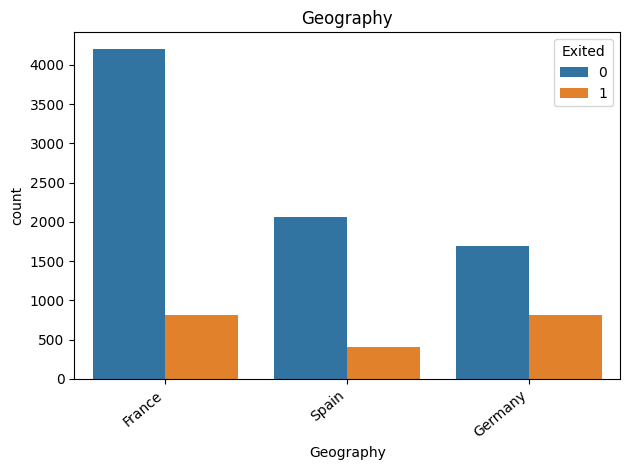

<ipython-input-15-fbdeaa3a343e>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


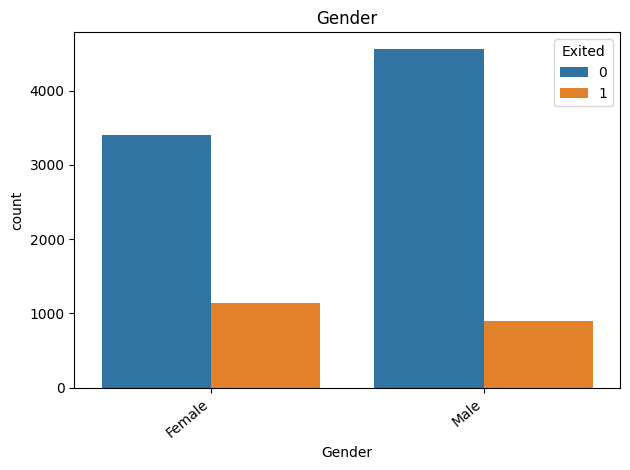

In [15]:
categorical_variables = [col for col in churn.select_dtypes(include='object').columns if col not in ['CustomerId', 'Surname','Exited']]

for col in categorical_variables:
    plt.figure()
    ax = sns.countplot(x=col, data=churn, hue='Exited')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.title(col)
    plt.tight_layout()

    plt.show()

# Checking Outliers

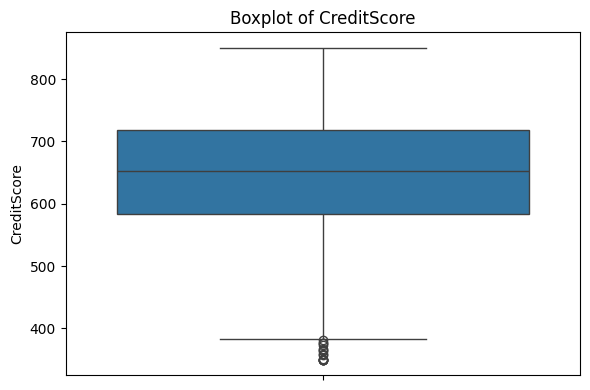

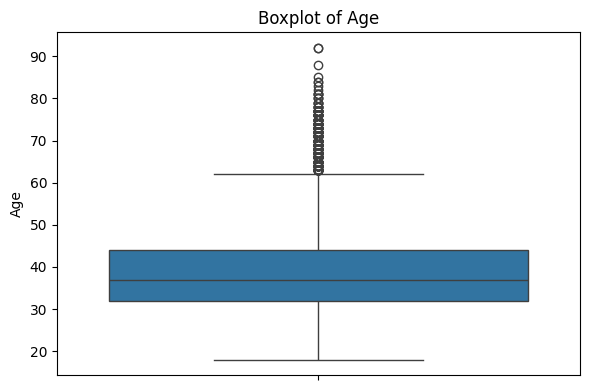

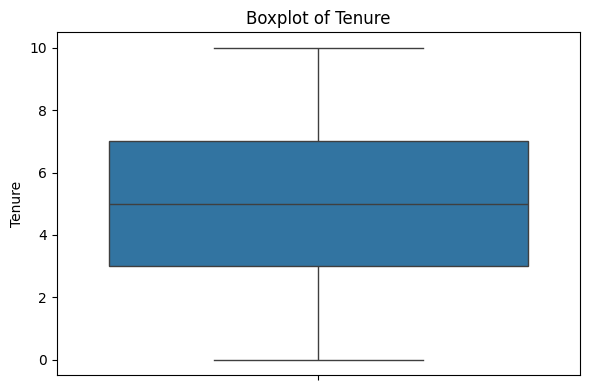

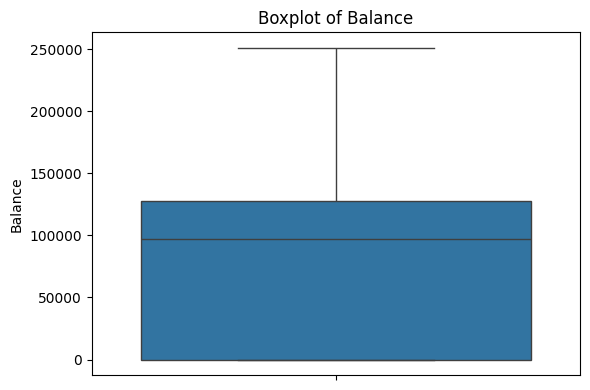

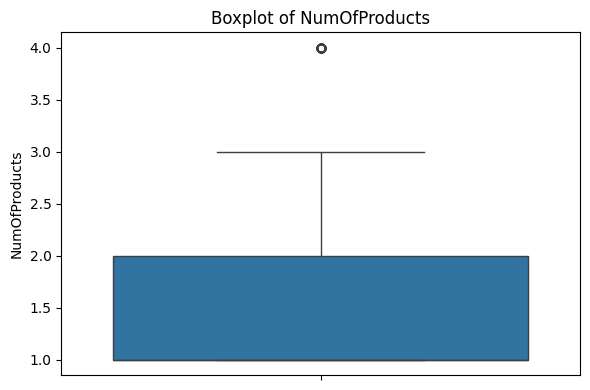

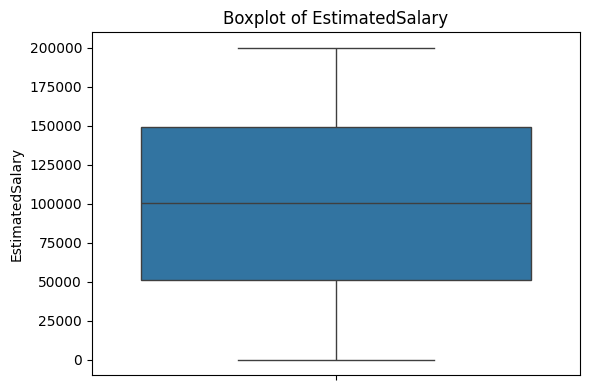

In [16]:
for col in numeric_columns:
    plt.figure(figsize=(6, 4))

 # Create boxplot with seaborn, optionally group by 'Exited'
    sns.boxplot(y=churn[col], data=churn)

    # Add title and labels
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

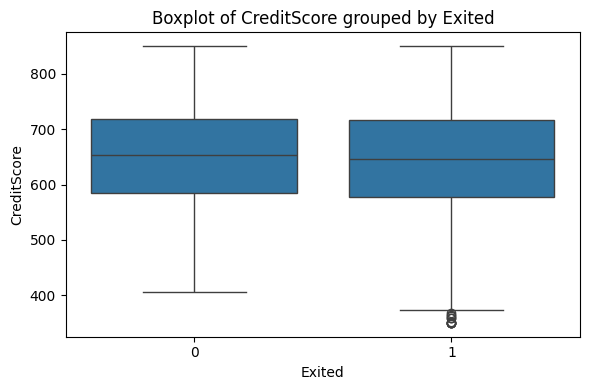

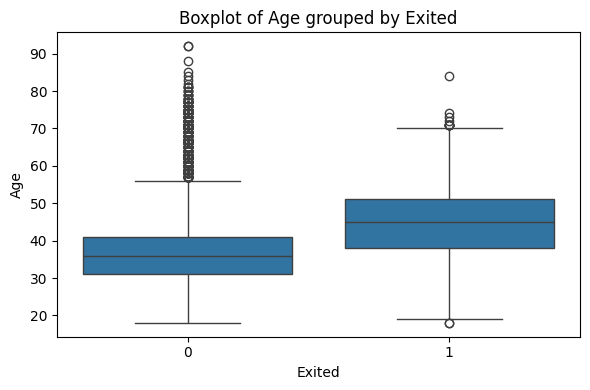

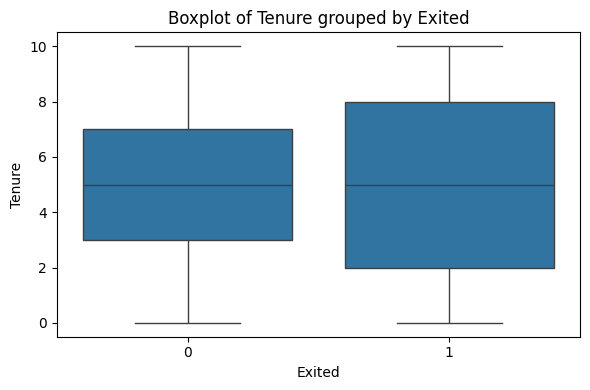

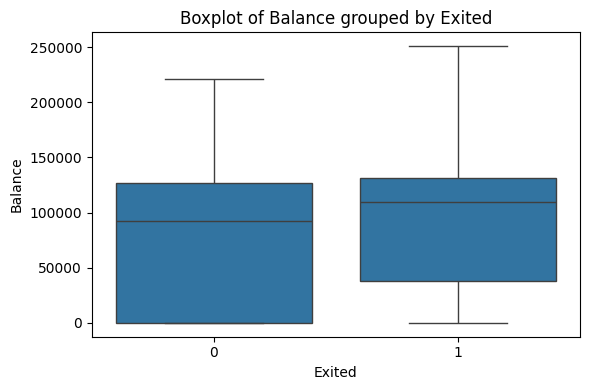

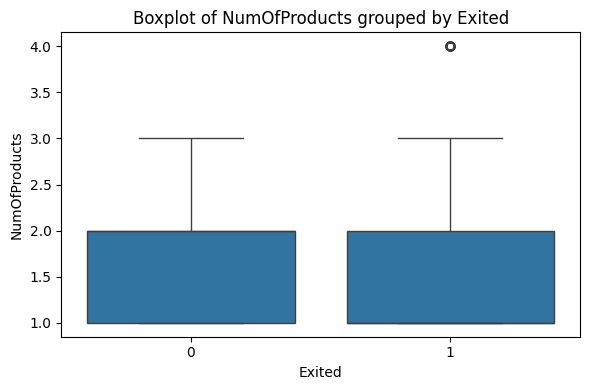

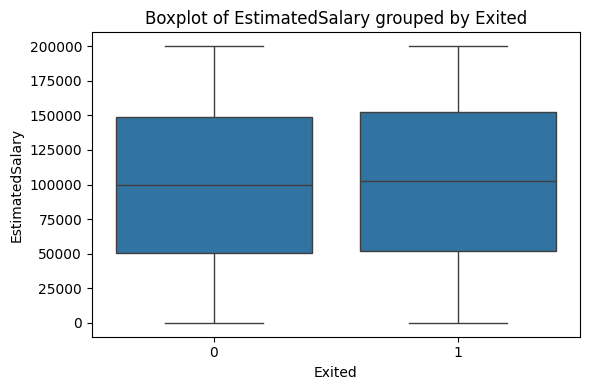

In [17]:
for col in numeric_columns:
    plt.figure(figsize=(6, 4))

    # Create boxplot with seaborn, optionally group by 'Exited'
    sns.boxplot(x=churn['Exited'], y=churn[col], data=churn)

    # Add title and labels
    plt.title(f'Boxplot of {col} grouped by Exited')
    plt.xlabel('Exited')
    plt.ylabel(col)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Observe correlations

Scatter Matrix (pairplot):
- Helps to identify the relationships between pairs of features.
- Useful for detecting linear and non-linear relationships, clusters, and outliers.
-Provides a comprehensive view of how features interact with each other.


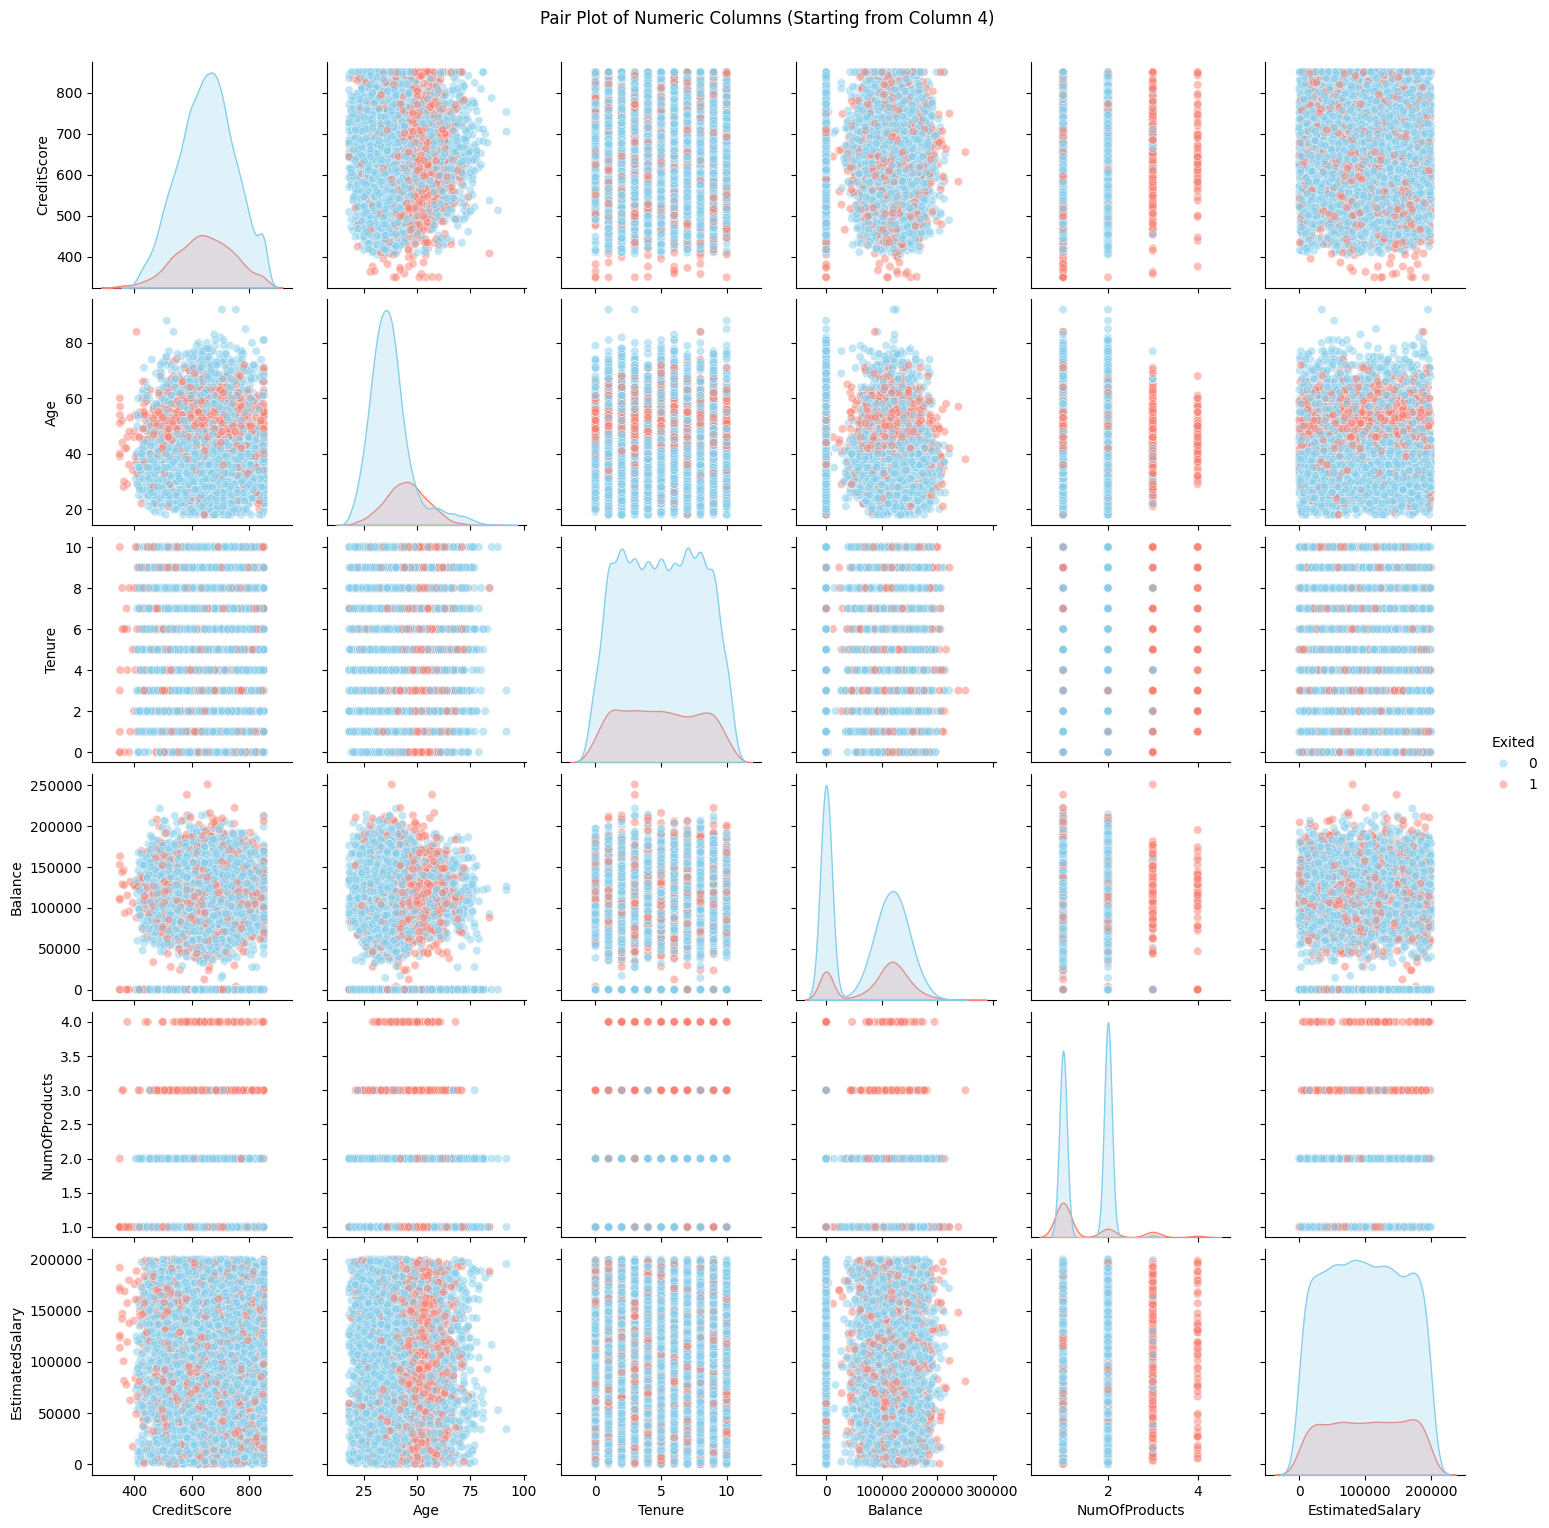

In [18]:
# Select only numeric columns from the fourth column onward
numeric_columns = churn.select_dtypes(include=['number']).columns[1:]

# Filter out columns with only values 0 and 1
relevant_columns = [col for col in numeric_columns if not set(churn[col].unique()).issubset({0, 1})]

# Add "Exited" column to the list for coloring and create a DataFrame with relevant columns
relevant_columns.append("Exited")
churn_relevant = churn[relevant_columns]

# Create a pair plot with different colors for "Exited" values
sns.pairplot(churn_relevant, hue="Exited", palette={0: "skyblue", 1: "salmon"}, plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot of Numeric Columns (Starting from Column 4)', y=1.02)
plt.show()


Correlation Matrix/Heatmap
- Identify relationships between variables/Pearson correlation coefficients for linear relationship
- Spot clusters of highly correlated variables.
- Identify redundant features that can be removed or combined.

In [19]:
numerical_variables = [col for col in churn.select_dtypes(exclude='object').columns if col not in ['CustomerId', 'Exited']]

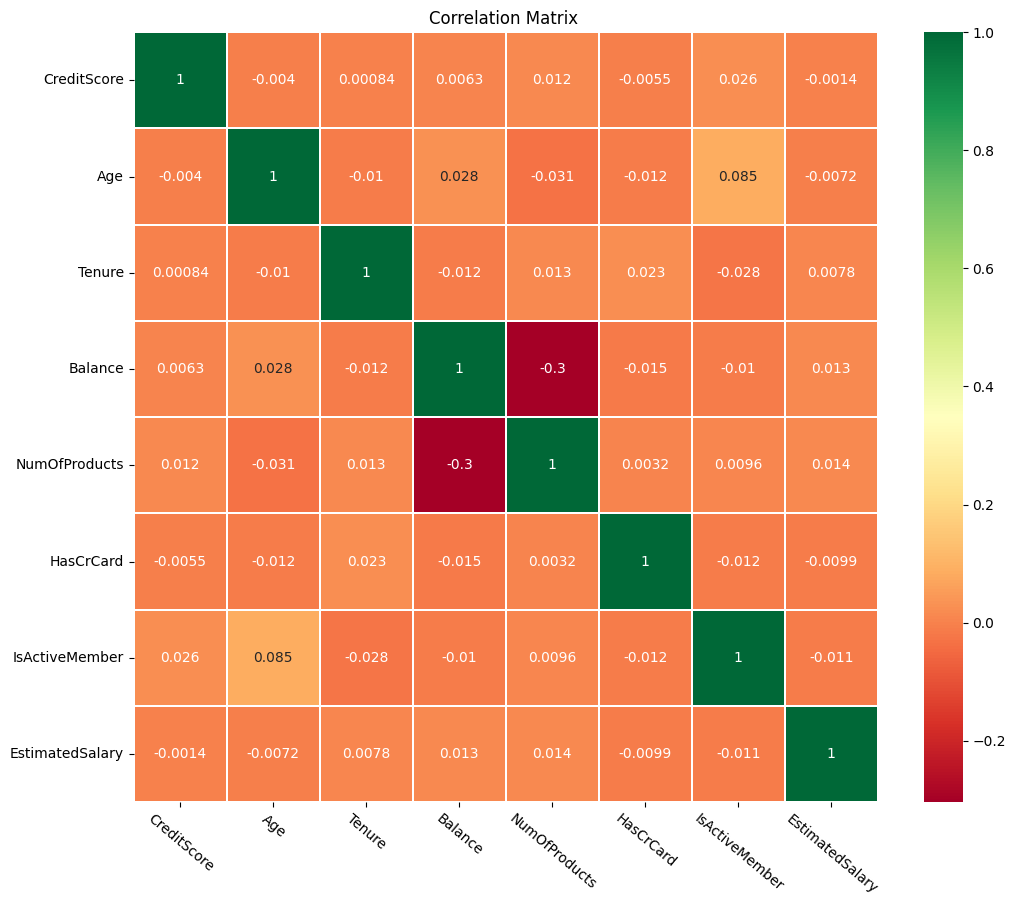

In [20]:
corr_matrix = churn[numerical_variables].corr()

cor_plot = sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.xticks(fontsize=10, rotation=-40)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix ')
plt.show()

# Summary

The dataset appears well-structured and complete, suggesting it has likely undergone some processing. No unexplainable outliers are present. There is no evident interrelationship among the numerical variables.

Observations related to churn behavior include:

* Product Count: Customers with three or more products exhibit a significantly higher churn rate. Excluding this group could be considered during the modeling process.
* Geography: German customers show a distinct churn pattern compared to those from France and Spain.
* Gender: Female customers have a higher churn rate than male customers.
* Active Membership: Active members tend to have a lower churn rate.
* Balance: Accounts with a balance of zero behave differently than those with a positive balance, potentially warranting a separate categorical consideration.
* Credit Score: Lower credit scores may correlate with increased churn risk.
* Age: Churn rates appear notably higher among customers aged 40 to 60.



# Pre-Processing

In [21]:
churn.drop(columns=['Surname', 'CustomerId'], inplace=True)

## Making a new categorical variable of Zero Balance or Balance Percentile:

In [22]:
# Define minimum and maximum for positive balances
min_balance = churn.loc[churn['Balance'] > 0, 'Balance'].min()
max_balance = churn['Balance'].max()

# Calculate evenly spaced cutoffs (10 intervals) from min_balance to max_balance
cutoffs = np.linspace(min_balance, max_balance, 10)

# Define labels for each decile (10 labels, one for each decile)
decile_labels = [f'Decile {i+1}' for i in range(10)]

# Assign each balance to the appropriate decile based on these evenly spaced cutoffs
# Add an additional bin edge (-np.inf) for zero balances
churn['Balance_Category'] = pd.cut(
  churn['Balance'],
  bins=[-np.inf, 0] + list(cutoffs),  # Add zero as a separate category
  labels=['Zero Balance'] + decile_labels,     # Add "Zero Balance" label
  include_lowest=True
)


## Get dummies

In [23]:
dummies = pd.get_dummies(churn, drop_first=False)
dummies.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,...,Balance_Category_Decile 1,Balance_Category_Decile 2,Balance_Category_Decile 3,Balance_Category_Decile 4,Balance_Category_Decile 5,Balance_Category_Decile 6,Balance_Category_Decile 7,Balance_Category_Decile 8,Balance_Category_Decile 9,Balance_Category_Decile 10
0,619,42,2,0.00,1,1,1,101348.88,1,True,...,False,False,False,False,False,False,False,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,...,False,False,False,True,False,False,False,False,False,False
2,502,42,8,159660.80,3,1,0,113931.57,1,True,...,False,False,False,False,False,False,True,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,True,...,False,False,False,False,False,False,False,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,...,False,False,False,False,False,True,False,False,False,False


In [24]:
dummies[dummies.select_dtypes(['bool']).columns] = dummies.select_dtypes(['bool']).astype(int)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CreditScore                    10000 non-null  int64  
 1   Age                            10000 non-null  int64  
 2   Tenure                         10000 non-null  int64  
 3   Balance                        10000 non-null  float64
 4   NumOfProducts                  10000 non-null  int64  
 5   HasCrCard                      10000 non-null  int64  
 6   IsActiveMember                 10000 non-null  int64  
 7   EstimatedSalary                10000 non-null  float64
 8   Exited                         10000 non-null  int64  
 9   Geography_France               10000 non-null  int64  
 10  Geography_Germany              10000 non-null  int64  
 11  Geography_Spain                10000 non-null  int64  
 12  Gender_Female                  10000 non-null  

In [25]:
dummies.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00
Geography_France,10000.0,0.501400,0.500023,0.00,0.00,1.000,1.0000,1.00


# Model Objectives:

To build an effective churn prediction model, the primary focus will be on recall and precision to ensure that the model captures as many potential churners as possible while minimizing false positives:

Therfore, metric Priorities for Bank Churn Prediction should be prioritized as follows:

* **Recall:** Prioritize high recall to ensure most potential churners are identified.
* **Precision:** Maintain high precision to reduce unnecessary intervention costs on customers who are not at risk.
* **Accuracy:** Not a primary focus due to data imbalance. To be tracked to provide an overall performance picture.
* **F1 Score:** F1 score as a balanced metric to assess the overall performance between recall and precision.

### Split the training set into train test

In [26]:
# Define features (X) and target (y)
X = dummies.drop(columns=['Exited'])
y = dummies['Exited']

# Split the data into training and testing sets, keeping the "Exited" category stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of the "Exited" category in the train and test sets
print("Train 'Exited' distribution:\n", y_train.value_counts(normalize=True))
print("Test 'Exited' distribution:\n", y_test.value_counts(normalize=True))


Train 'Exited' distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
Test 'Exited' distribution:
 Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


#Training

In [43]:
# Define pipelines for models that benefit from scaling
logistic_regression_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression(random_state=0, class_weight='balanced'))
])

knn_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', KNeighborsClassifier(3))
])

svm_pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42))
])

# Metrics and model names
SCORES = ['f1_1', 'f1_0', 'AUC', 'precision_1', 'precision_0', 'recall_1', 'recall_0']
names = ["LogisticRegression", "Nearest Neighbors", "Support Vector Machine", "Decision Tree",
         "Random Forest", "GradientBoost"]

# List of classifiers with selective scaling
classifiers = [
  logistic_regression_pipeline,
  knn_pipeline,
  svm_pipeline,
  DecisionTreeClassifier(max_depth=5, class_weight='balanced'),
  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight='balanced'),
  XGBClassifier(random_state=42),
]


In [44]:
results = {}

# iterate over classifiers
for name, clf in zip(names, classifiers):
    classifier_result = {}
    print(f"CLASSIFIER: {name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'Classification report: {classification_report(y_test, y_pred)}')
    classifier_result['f1_1'] = f1_score(y_test, y_pred, pos_label=1, average='binary')
    classifier_result['f1_0'] = f1_score(y_test, y_pred, pos_label=0, average='binary')
    classifier_result['AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    classifier_result['precision_1'] = precision_score(y_test, y_pred, pos_label=1, average='binary')
    classifier_result['precision_0'] = precision_score(y_test, y_pred, pos_label=0, average='binary')
    classifier_result['recall_1'] = recall_score(y_test, y_pred, pos_label=1, average='binary')
    classifier_result['recall_0'] = recall_score(y_test, y_pred, pos_label=0, average='binary')
    results[name] = classifier_result

CLASSIFIER: LogisticRegression
Classification report:               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1593
           1       0.39      0.71      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.80      0.72      0.74      2000

CLASSIFIER: Nearest Neighbors
Classification report:               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1593
           1       0.57      0.38      0.46       407

    accuracy                           0.82      2000
   macro avg       0.71      0.66      0.67      2000
weighted avg       0.80      0.82      0.80      2000

CLASSIFIER: Support Vector Machine
Classification report:               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1593
           1       0.40      0.71      0.51       407

    accuracy     

In [34]:
df_results = pd.DataFrame(results).T.reset_index()
df_results

,index,f1_1,f1_0,AUC,precision_1,precision_0,recall_1,recall_0
0,LogisticRegression,0.506527,0.801122,0.780239,0.392183,0.907790,0.714988,0.716886
1,Nearest Neighbors,0.459499,0.889491,0.720020,0.573529,0.854745,0.383292,0.927181
2,Support Vector Machine,0.511464,0.806699,0.778015,0.398900,0.908091,0.712531,0.725675
3,Decision Tree,0.575092,0.840440,0.837556,0.458394,0.929278,0.771499,0.767106
4,Random Forest,0.513915,0.820671,0.796056,0.412817,0.902182,0.680590,0.752668
5,GradientBoost,0.609091,0.922754,0.871246,0.794466,0.882084,0.493857,0.967357


f1 scores looks promising for simple decision tree and gradient boost models. We will continue to try to improve them using optuna, along with random forest for further investigation

#Hyperparameter tuning, using optuna


In [ ]:
!pip install optuna

In [36]:
import optuna
import logging

## The following models will be tuned using optuna, using cross-validation, and evaluated by finding the optimal threshold

Best Parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 9}
Best Cross-Validation Score: 0.5671368968282323
Optimal Threshold for Best F1: 0.65
Test Accuracy: 0.8105
Precision: 0.5282258064516129
Recall: 0.6437346437346437
F1 Score: 0.5802879291251384


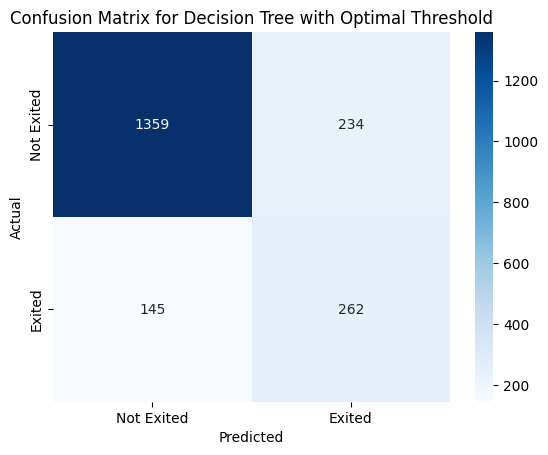


Feature Importance:
                          Feature    Importance
1                             Age  4.333934e-01
4                   NumOfProducts  3.128209e-01
3                         Balance  1.174871e-01
6                  IsActiveMember  6.541834e-02
9               Geography_Germany  4.527993e-02
12                    Gender_Male  8.741740e-03
7                 EstimatedSalary  5.553676e-03
19      Balance_Category_Decile 6  5.221759e-03
0                     CreditScore  4.405143e-03
10                Geography_Spain  1.502107e-03
2                          Tenure  1.759927e-04
11                  Gender_Female  2.542521e-17
8                Geography_France  0.000000e+00
5                       HasCrCard  0.000000e+00
13  Balance_Category_Zero Balance  0.000000e+00
14      Balance_Category_Decile 1  0.000000e+00
15      Balance_Category_Decile 2  0.000000e+00
16      Balance_Category_Decile 3  0.000000e+00
17      Balance_Category_Decile 4  0.000000e+00
18      Balance_Cat

In [41]:
# Decision Tree

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  max_depth = trial.suggest_int('max_depth', 3, 20)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

  # Create a pipeline with scaling and DecisionTreeClassifier
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      class_weight='balanced',
      random_state=42
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('dt', DecisionTreeClassifier(**study.best_params, class_weight='balanced', random_state=42))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable (Feature Importance)
# Extract the feature importances
feature_importances = best_model.named_steps['dt'].feature_importances_
feature_importance_df = pd.DataFrame({
  'Feature': X_train.columns,
  'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Importance:")
print(feature_importance_df)

best_dt_model = best_model
best_dt_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/dt_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)

Best Parameters: {'n_estimators': 63, 'max_depth': 7, 'learning_rate': 0.12866157330486364, 'subsample': 0.8157896024072344, 'colsample_bytree': 0.9525883430843656}
Best Cross-Validation Score: 0.5899255720106016
Optimal Threshold for Best F1: 0.37


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:33:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.8545
Precision: 0.6647727272727273
Recall: 0.5749385749385749
F1 Score: 0.616600790513834


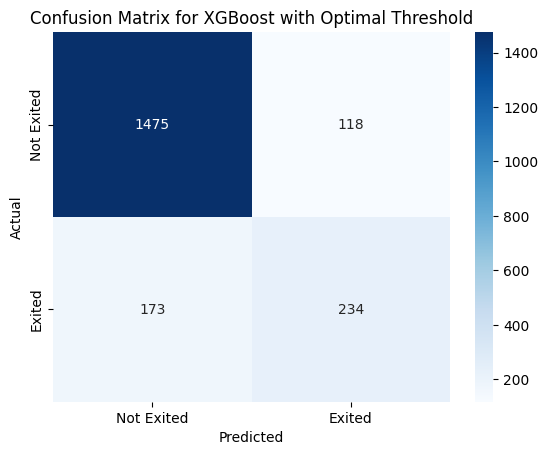


Feature Importance:
                          Feature  Importance
4                   NumOfProducts    0.254445
6                  IsActiveMember    0.096657
1                             Age    0.080300
13  Balance_Category_Zero Balance    0.071629
9               Geography_Germany    0.069521
12                    Gender_Male    0.040961
3                         Balance    0.035291
16      Balance_Category_Decile 3    0.029816
17      Balance_Category_Decile 4    0.027749
19      Balance_Category_Decile 6    0.026975
11                  Gender_Female    0.026785
21      Balance_Category_Decile 8    0.025901
10                Geography_Spain    0.025876
8                Geography_France    0.024482
0                     CreditScore    0.023371
7                 EstimatedSalary    0.023346
5                       HasCrCard    0.022437
18      Balance_Category_Decile 5    0.021105
2                          Tenure    0.020684
15      Balance_Category_Decile 2    0.018336
20      Balan

In [42]:
# XGBoost

from xgboost import XGBClassifier


# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  n_estimators = trial.suggest_int('n_estimators', 50, 300)
  max_depth = trial.suggest_int('max_depth', 3, 20)
  learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
  subsample = trial.suggest_float('subsample', 0.5, 1.0)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

  # Create a pipeline with scaling and XGBoost classifier
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
      n_estimators=n_estimators, max_depth=max_depth,
      learning_rate=learning_rate, subsample=subsample,
      colsample_bytree=colsample_bytree, random_state=42, eval_metric='logloss'
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('xgb', XGBClassifier(**study.best_params, random_state=42, eval_metric='logloss'))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable (Feature Importance)
# Extract the feature importances
feature_importances = best_model.named_steps['xgb'].feature_importances_
feature_importance_df = pd.DataFrame({
  'Feature': X_train.columns,
  'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Importance:")
print(feature_importance_df)

best_xgb_model = best_model
best_xgb_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/xgb_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)

Best Parameters: {'n_estimators': 96, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}
Best Cross-Validation Score: 0.6276126179926808
Optimal Threshold for Best F1: 0.50
Test Accuracy: 0.841
Precision: 0.5944798301486199
Recall: 0.687960687960688
F1 Score: 0.6378132118451025


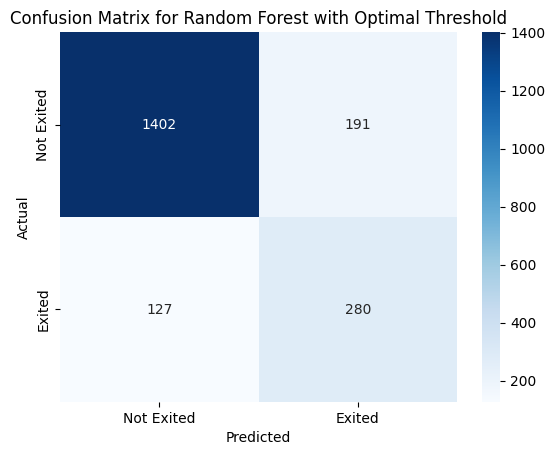


Feature Impact:
                          Feature  Importance
1                             Age    0.290537
4                   NumOfProducts    0.168127
3                         Balance    0.090024
7                 EstimatedSalary    0.090003
0                     CreditScore    0.089952
2                          Tenure    0.055635
6                  IsActiveMember    0.049384
9               Geography_Germany    0.041202
13  Balance_Category_Zero Balance    0.019563
12                    Gender_Male    0.016525
8                Geography_France    0.015713
11                  Gender_Female    0.012680
5                       HasCrCard    0.012565
10                Geography_Spain    0.011082
19      Balance_Category_Decile 6    0.010694
18      Balance_Category_Decile 5    0.007112
17      Balance_Category_Decile 4    0.006169
21      Balance_Category_Decile 8    0.005418
20      Balance_Category_Decile 7    0.005016
16      Balance_Category_Decile 3    0.001693
22      Balance_C

In [37]:
# random forest

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Number of trees
  max_depth = trial.suggest_int('max_depth', 3, 20)  # Depth of each tree
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Minimum samples in leaf nodes
  max_features = trial.suggest_categorical('max_features', [1, 'sqrt', 'log2'])

  # Create a pipeline with scaling and random forest
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
      n_estimators=n_estimators, max_depth=max_depth,
      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
      random_state=42, class_weight='balanced', max_features=max_features
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('rf', RandomForestClassifier(**study.best_params, random_state=42, class_weight='balanced'))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable
# Extract the feature importances
importances = best_model.named_steps['rf'].feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Impact:")
print(feature_importance)

best_rf_model = best_model
best_rf_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/rf_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)


## Since the categorial balance and the numeric balance are mixed up in the above models, we will try optuna with only the categorical variable



In [45]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = dummies.drop(columns=['Exited', 'Balance'])
y = dummies['Exited']

# Split the data into training and testing sets, keeping the "Exited" category stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of the "Exited" category in the train and test sets
print("Train 'Exited' distribution:\n", y_train.value_counts(normalize=True))
print("Test 'Exited' distribution:\n", y_test.value_counts(normalize=True))


Train 'Exited' distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
Test 'Exited' distribution:
 Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


Best Parameters: {'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 6}
Best Cross-Validation Score: 0.5694104368243099
Optimal Threshold for Best F1: 0.65
Test Accuracy: 0.841
Precision: 0.6013667425968109
Recall: 0.6486486486486487
F1 Score: 0.624113475177305


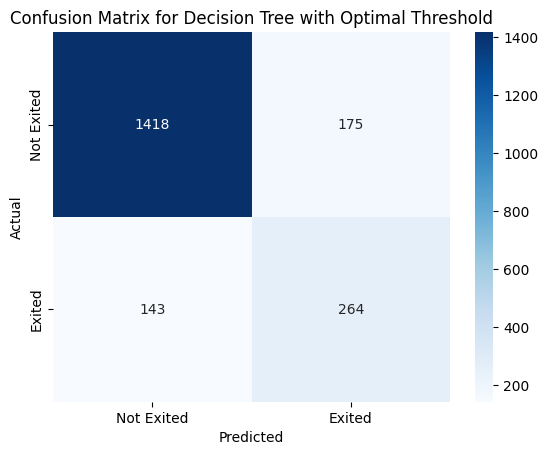


Feature Importance:
                          Feature  Importance
1                             Age    0.429709
3                   NumOfProducts    0.295647
5                  IsActiveMember    0.075323
12  Balance_Category_Zero Balance    0.066719
8               Geography_Germany    0.043719
0                     CreditScore    0.023141
6                 EstimatedSalary    0.018719
11                    Gender_Male    0.009948
20      Balance_Category_Decile 8    0.009793
16      Balance_Category_Decile 4    0.009214
2                          Tenure    0.008681
18      Balance_Category_Decile 6    0.007319
9                 Geography_Spain    0.001414
4                       HasCrCard    0.000655
7                Geography_France    0.000000
10                  Gender_Female    0.000000
13      Balance_Category_Decile 1    0.000000
14      Balance_Category_Decile 2    0.000000
15      Balance_Category_Decile 3    0.000000
17      Balance_Category_Decile 5    0.000000
19      Balan

In [46]:
# Decision Tree - categorical balance

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  max_depth = trial.suggest_int('max_depth', 3, 20)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

  # Create a pipeline with scaling and DecisionTreeClassifier
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      class_weight='balanced',
      random_state=42
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('dt', DecisionTreeClassifier(**study.best_params, class_weight='balanced', random_state=42))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable (Feature Importance)
# Extract the feature importances
feature_importances = best_model.named_steps['dt'].feature_importances_
feature_importance_df = pd.DataFrame({
  'Feature': X_train.columns,
  'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Importance:")
print(feature_importance_df)

best_dt_xb_model = best_model
best_dt_xb_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/dt_xb_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)

Best Parameters: {'n_estimators': 215, 'max_depth': 4, 'learning_rate': 0.07061956737193914, 'subsample': 0.8252411119631382, 'colsample_bytree': 0.849546226415591}
Best Cross-Validation Score: 0.5906641601773693


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:53:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimal Threshold for Best F1: 0.35
Test Accuracy: 0.858
Precision: 0.6597402597402597
Recall: 0.6240786240786241
F1 Score: 0.6414141414141414


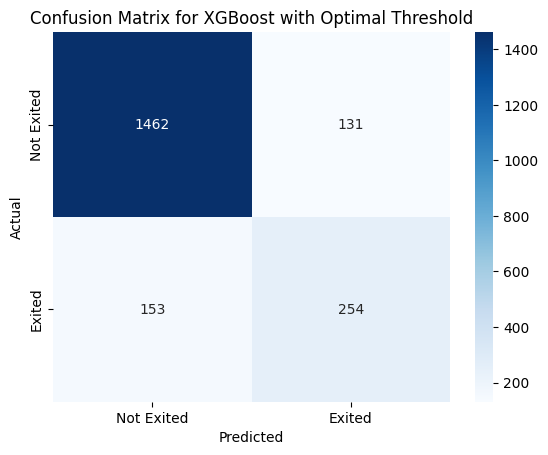


Feature Importance:
                          Feature  Importance
3                   NumOfProducts    0.158657
5                  IsActiveMember    0.137463
1                             Age    0.112312
8               Geography_Germany    0.075519
12  Balance_Category_Zero Balance    0.057175
10                  Gender_Female    0.042271
20      Balance_Category_Decile 8    0.042206
16      Balance_Category_Decile 4    0.041956
11                    Gender_Male    0.037122
7                Geography_France    0.036691
15      Balance_Category_Decile 3    0.032611
18      Balance_Category_Decile 6    0.030395
17      Balance_Category_Decile 5    0.027611
9                 Geography_Spain    0.027286
21      Balance_Category_Decile 9    0.026768
0                     CreditScore    0.021645
6                 EstimatedSalary    0.020413
2                          Tenure    0.019010
19      Balance_Category_Decile 7    0.018763
4                       HasCrCard    0.017654
14      Balan

In [47]:
# XGBoost - categorical balance

from xgboost import XGBClassifier


# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  n_estimators = trial.suggest_int('n_estimators', 50, 300)
  max_depth = trial.suggest_int('max_depth', 3, 20)
  learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
  subsample = trial.suggest_float('subsample', 0.5, 1.0)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

  # Create a pipeline with scaling and XGBoost classifier
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
      n_estimators=n_estimators, max_depth=max_depth,
      learning_rate=learning_rate, subsample=subsample,
      colsample_bytree=colsample_bytree, random_state=42, eval_metric='logloss'
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('xgb', XGBClassifier(**study.best_params, random_state=42, eval_metric='logloss'))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable (Feature Importance)
# Extract the feature importances
feature_importances = best_model.named_steps['xgb'].feature_importances_
feature_importance_df = pd.DataFrame({
  'Feature': X_train.columns,
  'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Importance:")
print(feature_importance_df)

best_xgb_xb_model = best_model
best_xgb_xb_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/xgb_xb_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)

Best Parameters: {'n_estimators': 180, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Cross-Validation Score: 0.6209857785597218
Optimal Threshold for Best F1: 0.46
Test Accuracy: 0.8285
Precision: 0.5634920634920635
Recall: 0.6977886977886978
F1 Score: 0.6234906695938529


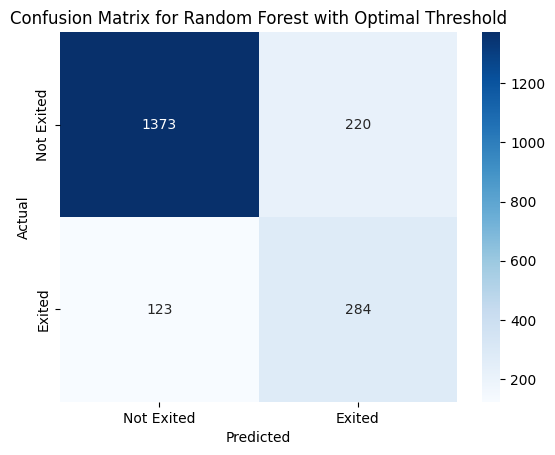


Feature Impact:
                          Feature  Importance
1                             Age    0.305615
3                   NumOfProducts    0.180719
6                 EstimatedSalary    0.100880
0                     CreditScore    0.097345
2                          Tenure    0.062858
5                  IsActiveMember    0.051400
8               Geography_Germany    0.039454
12  Balance_Category_Zero Balance    0.027364
7                Geography_France    0.017699
4                       HasCrCard    0.015778
18      Balance_Category_Decile 6    0.015560
10                  Gender_Female    0.015277
11                    Gender_Male    0.014299
9                 Geography_Spain    0.011128
16      Balance_Category_Decile 4    0.010238
17      Balance_Category_Decile 5    0.010101
20      Balance_Category_Decile 8    0.009670
19      Balance_Category_Decile 7    0.008255
15      Balance_Category_Decile 3    0.003973
21      Balance_Category_Decile 9    0.001954
14      Balance_C

In [48]:
# random forest - categorical balance

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Number of trees
  max_depth = trial.suggest_int('max_depth', 3, 20)  # Depth of each tree
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Minimum samples in leaf nodes
  max_features = trial.suggest_categorical('max_features', [1, 'sqrt', 'log2'])

  # Create a pipeline with scaling and random forest
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
      n_estimators=n_estimators, max_depth=max_depth,
      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
      random_state=42, class_weight='balanced', max_features=max_features
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('rf', RandomForestClassifier(**study.best_params, random_state=42, class_weight='balanced'))
])
best_model.fit(X_train, y_train)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable
# Extract the feature importances
importances = best_model.named_steps['rf'].feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Impact:")
print(feature_importance)

best_rf_xb_model = best_model
best_rf_xb_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/rf_xb_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)


## Use of oversampling

In [49]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where
from imblearn.under_sampling import RandomUnderSampler

In [50]:
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train)
counter = Counter(y_over)
counter

Counter({1: 6370, 0: 6370})

Best Parameters: {'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5}
Best Cross-Validation Score: 0.8306563827461882
Optimal Threshold for Best F1: 0.32
Test Accuracy: 0.789
Precision: 0.48717948717948717
Recall: 0.7002457002457002
F1 Score: 0.5745967741935484


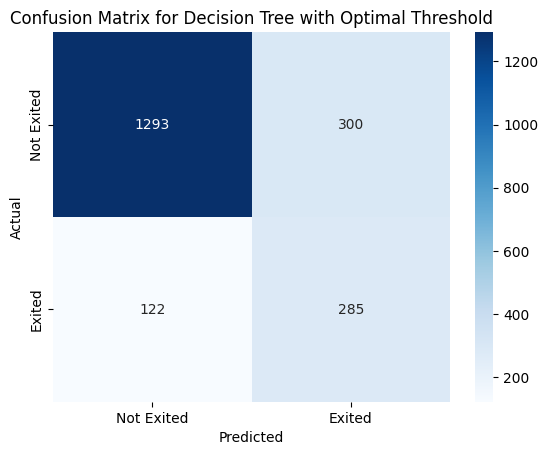


Feature Importance:
                          Feature  Importance
1                             Age    0.266324
5                  IsActiveMember    0.146883
8               Geography_Germany    0.118903
3                   NumOfProducts    0.118882
9                 Geography_Spain    0.086036
7                Geography_France    0.064274
10                  Gender_Female    0.061771
12  Balance_Category_Zero Balance    0.044176
11                    Gender_Male    0.035404
17      Balance_Category_Decile 5    0.016263
18      Balance_Category_Decile 6    0.013739
19      Balance_Category_Decile 7    0.013437
0                     CreditScore    0.006801
6                 EstimatedSalary    0.004572
2                          Tenure    0.001806
4                       HasCrCard    0.000365
20      Balance_Category_Decile 8    0.000363
13      Balance_Category_Decile 1    0.000000
14      Balance_Category_Decile 2    0.000000
15      Balance_Category_Decile 3    0.000000
16      Balan

In [51]:
# Decision Tree - categorical balance - oversampling

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  max_depth = trial.suggest_int('max_depth', 3, 20)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

  # Create a pipeline with scaling and DecisionTreeClassifier
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      min_samples_leaf=min_samples_leaf,
      class_weight='balanced',
      random_state=42
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_over, y_over, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('dt', DecisionTreeClassifier(**study.best_params, class_weight='balanced', random_state=42))
])
best_model.fit(X_over, y_over)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable (Feature Importance)
# Extract the feature importances
feature_importances = best_model.named_steps['dt'].feature_importances_
feature_importance_df = pd.DataFrame({
  'Feature': X_over.columns,
  'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Importance:")
print(feature_importance_df)

best_dt_os_model = best_model
best_dt_os_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/dt_os_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)

Best Parameters: {'n_estimators': 211, 'max_depth': 19, 'learning_rate': 0.05928412914605199, 'subsample': 0.577088677647438, 'colsample_bytree': 0.7224088825874077}
Best Cross-Validation Score: 0.8662537781769248
Optimal Threshold for Best F1: 0.29
Test Accuracy: 0.8265
Precision: 0.5638297872340425
Recall: 0.6511056511056511
F1 Score: 0.6043329532497149


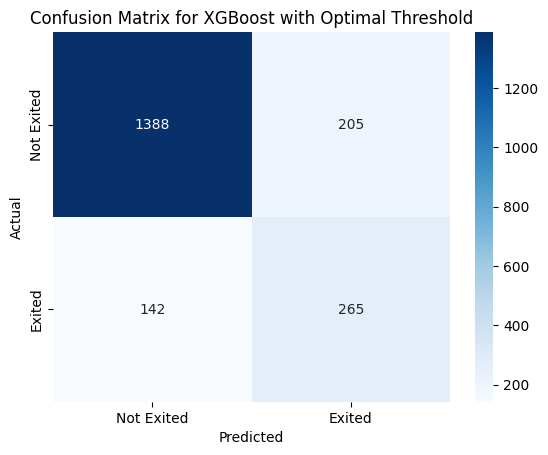


Feature Importance:
                          Feature  Importance
5                  IsActiveMember    0.106779
9                 Geography_Spain    0.076953
16      Balance_Category_Decile 4    0.075316
15      Balance_Category_Decile 3    0.069424
3                   NumOfProducts    0.069097
12  Balance_Category_Zero Balance    0.060418
7                Geography_France    0.060037
20      Balance_Category_Decile 8    0.059459
19      Balance_Category_Decile 7    0.058319
11                    Gender_Male    0.056647
8               Geography_Germany    0.052701
10                  Gender_Female    0.051576
17      Balance_Category_Decile 5    0.046598
21      Balance_Category_Decile 9    0.038950
18      Balance_Category_Decile 6    0.038488
1                             Age    0.030067
6                 EstimatedSalary    0.013360
0                     CreditScore    0.012489
4                       HasCrCard    0.011848
2                          Tenure    0.011471
14      Balan

In [52]:
# XGBoost - categorical balance - oversampling

from xgboost import XGBClassifier


# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  n_estimators = trial.suggest_int('n_estimators', 50, 300)
  max_depth = trial.suggest_int('max_depth', 3, 20)
  learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
  subsample = trial.suggest_float('subsample', 0.5, 1.0)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

  # Create a pipeline with scaling and XGBoost classifier
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
      n_estimators=n_estimators, max_depth=max_depth,
      learning_rate=learning_rate, subsample=subsample,
      colsample_bytree=colsample_bytree, random_state=42, eval_metric='logloss'
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_over, y_over, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('xgb', XGBClassifier(**study.best_params, random_state=42, eval_metric='logloss'))
])
best_model.fit(X_over, y_over)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable (Feature Importance)
# Extract the feature importances
feature_importances = best_model.named_steps['xgb'].feature_importances_
feature_importance_df = pd.DataFrame({
  'Feature': X_over.columns,
  'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Importance:")
print(feature_importance_df)

best_xgb_os_model = best_model
best_xgb_os_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/xgb_os_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)

Best Parameters: {'n_estimators': 287, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Cross-Validation Score: 0.852331349676224
Optimal Threshold for Best F1: 0.35
Test Accuracy: 0.817
Precision: 0.5381750465549349
Recall: 0.7100737100737101
F1 Score: 0.6122881355932204


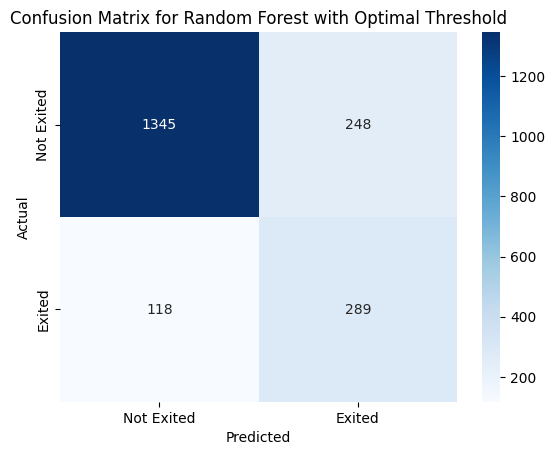


Feature Impact:
                          Feature  Importance
1                             Age    0.181952
5                  IsActiveMember    0.098424
3                   NumOfProducts    0.091901
6                 EstimatedSalary    0.074386
7                Geography_France    0.073908
0                     CreditScore    0.070038
12  Balance_Category_Zero Balance    0.062872
11                    Gender_Male    0.062310
2                          Tenure    0.047806
9                 Geography_Spain    0.045666
10                  Gender_Female    0.044733
8               Geography_Germany    0.027938
18      Balance_Category_Decile 6    0.024372
17      Balance_Category_Decile 5    0.024054
19      Balance_Category_Decile 7    0.020856
4                       HasCrCard    0.018568
16      Balance_Category_Decile 4    0.018041
20      Balance_Category_Decile 8    0.007239
15      Balance_Category_Decile 3    0.003314
21      Balance_Category_Decile 9    0.001271
14      Balance_C

In [53]:
# random forest - categorical balance - oversampling

# Suppress Optuna's verbose output by setting the logging level to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function for Optuna
def objective(trial):
  # Define hyperparameters to tune
  n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Number of trees
  max_depth = trial.suggest_int('max_depth', 3, 20)  # Depth of each tree
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Minimum samples in leaf nodes
  max_features = trial.suggest_categorical('max_features', [1, 'sqrt', 'log2'])

  # Create a pipeline with scaling and random forest
  model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
      n_estimators=n_estimators, max_depth=max_depth,
      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
      random_state=42, class_weight='balanced', max_features=max_features
    ))
  ])

  # Perform cross-validation and return the mean F1 score
  score = cross_val_score(model, X_over, y_over, cv=5, scoring='f1').mean()
  return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best Parameters:", study.best_params)
print("Best Cross-Validation Score:", study.best_value)

# Train the final model with the best parameters
best_model = Pipeline([
  ('scaler', StandardScaler()),
  ('rf', RandomForestClassifier(**study.best_params, random_state=42, class_weight='balanced'))
])
best_model.fit(X_over, y_over)

# Predict probabilities and find the optimal threshold using the Precision-Recall curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1: {optimal_threshold:.2f}")

# Use the optimal threshold to make final predictions
y_pred = (y_probs >= optimal_threshold).astype(int)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)
recall_final = recall_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)

# Print evaluation results
print("Test Accuracy:", accuracy)
print("Precision:", precision_final)
print("Recall:", recall_final)
print("F1 Score:", f1_final)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest with Optimal Threshold')
plt.show()

# Evaluate the impact of each variable
# Extract the feature importances
importances = best_model.named_steps['rf'].feature_importances_
feature_importance = pd.DataFrame({'Feature': X_over.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display feature impact
print("\nFeature Impact:")
print(feature_importance)

best_rf_os_model = best_model
best_rf_os_th = optimal_threshold

import pickle

model_data = {
  'model': best_model,
  'optimal_threshold': optimal_threshold
}

# Mount Google Drive
drive.mount('/content/drive')

# Define the path in Google Drive
file_path = '/content/drive/MyDrive/e-commerce project/rf_os_model.pkl'

# Save the file to Google Drive without compression
with open(file_path, 'wb') as f:
    pickle.dump(model_data, f)


## Apply selected model on validation set

In [ ]:
predictions_val = best_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_)
print("Test Accuracy:", accuracy)

# Get a classification report
report = classification_report(y_test, predictions_)
print("Classification Report:\n", report)

print(f"F1 0 class score: {f1_score(y_val, predictions_val, pos_label=0, average='binary')}")
print(f"F1 1 class score: {f1_score(y_val, predictions_val, pos_label=1, average='binary')}")
print(f"AUC: {roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])}")
print(f"Precision 0: {precision_score(y_val, predictions_val, pos_label=0, average='binary')}")
print(f"Precision 1: {precision_score(y_val, predictions_val, pos_label=1, average='binary')}")

Test Accuracy: 0.869
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000

F1 0 class score: 0.9185452359483017
F1 1 class score: 0.5973254086181278
AUC: 0.8725571417891433
Precision 0: 0.8781609195402299
Precision 1: 0.7730769230769231


In [ ]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_scores)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

NameError: name 'roc_curve' is not defined

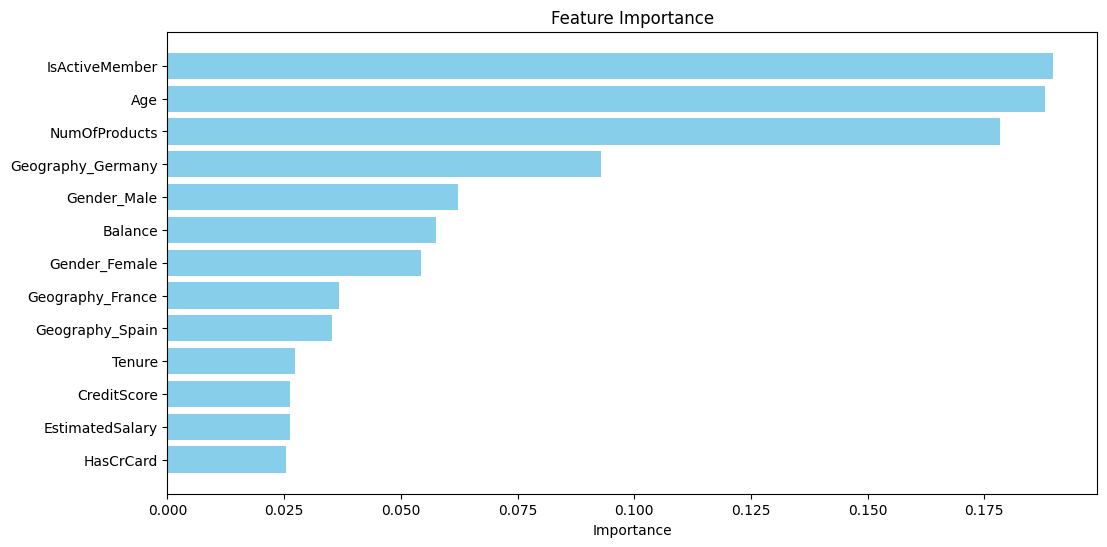

In [ ]:
importances = best_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

In [ ]:
importance_df

,Feature,Importance
6,IsActiveMember,0.189753
1,Age,0.187995
4,NumOfProducts,0.178460
9,Geography_Germany,0.092778
12,Gender_Male,0.062283
3,Balance,0.057439
11,Gender_Female,0.054212
8,Geography_France,0.036775
10,Geography_Spain,0.035161
2,Tenure,0.027296


## SHAP values

In [ ]:
import shap  # package used to calculate Shap values

# Fits the explainer
explainer = shap.Explainer(best_model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

PermutationExplainer explainer: 2001it [07:38,  4.33it/s]


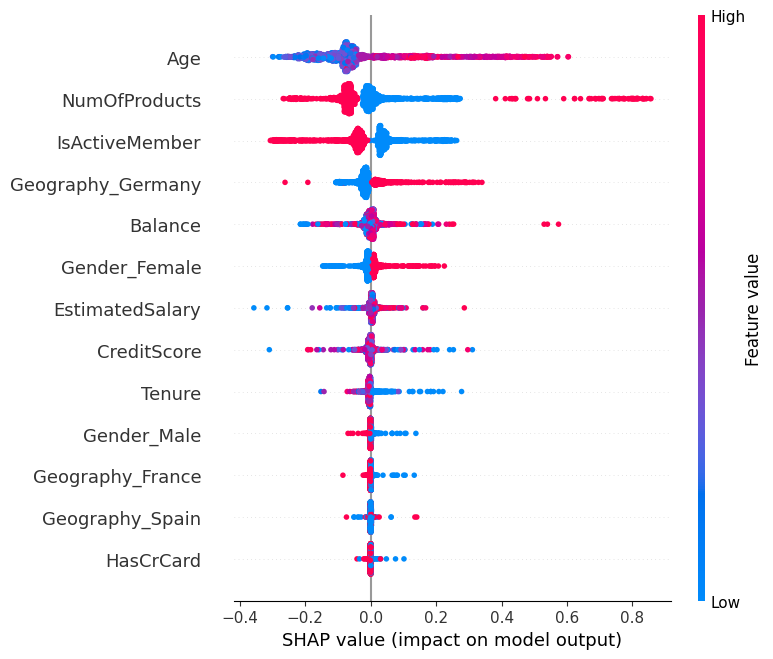

In [ ]:
fig=shap.summary_plot(shap_values)

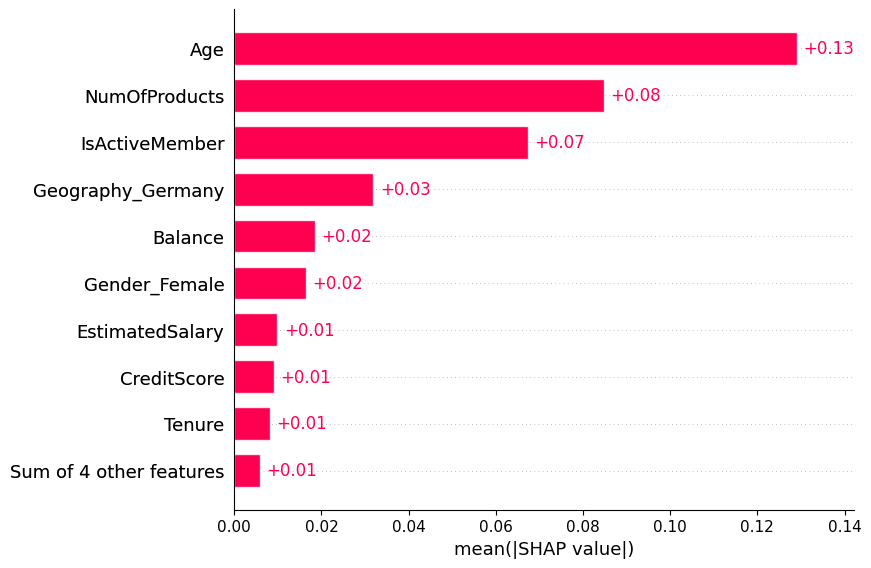

In [ ]:
shap.plots.bar(shap_values)

## Calculate Lift

In [ ]:
# Create a DataFrame with actual and predicted probabilities
results = pd.DataFrame({
    'True': y_val,
    'Predicted_Probabilities': y_scores
})

# Sort by predicted probabilities
results = results.sort_values(by='Predicted_Probabilities', ascending=False)

In [ ]:
# Define the number of bins
num_bins = 100

# Total number of positive cases
total_positives = results['True'].sum()

# Create bins and calculate lift
results['Bin'] = pd.qcut(results['Predicted_Probabilities'], num_bins, labels=False)
lift_data = results.groupby('Bin').agg(
    Positives=('True', 'sum'),
    Total=('True', 'count')
).reset_index()

# Calculate lift
lift_data['Lift'] = lift_data['Positives'] / total_positives
lift_data['Percentage'] = lift_data['Total'] / results.shape[0]  # Percentage of total instances
lift_data['Cumulative_Percentage'] = lift_data['Percentage'].cumsum()
lift_data['Cumulative_Lift'] = lift_data['Lift'].cumsum()

lift_data_srtd=lift_data.sort_values(by='Bin', ascending=False)
lift_data_srtd.head(60)

,Bin,Positives,Total,Lift,Percentage,Cumulative_Percentage,Cumulative_Lift
99,99,20,20,0.048426,0.01,1.00,1.000000
98,98,19,20,0.046005,0.01,0.99,0.951574
97,97,18,20,0.043584,0.01,0.98,0.905569
96,96,19,20,0.046005,0.01,0.97,0.861985
95,95,18,20,0.043584,0.01,0.96,0.815981
94,94,19,20,0.046005,0.01,0.95,0.772397
93,93,20,20,0.048426,0.01,0.94,0.726392
92,92,15,20,0.036320,0.01,0.93,0.677966
91,91,13,20,0.031477,0.01,0.92,0.641646
90,90,13,20,0.031477,0.01,0.91,0.610169


In [ ]:
lift_data_srtd.tail(50)

,Bin,Positives,Total,Lift,Percentage,Cumulative_Percentage,Cumulative_Lift
49,49,2,20,0.004843,0.01,0.50,0.094431
48,48,0,20,0.000000,0.01,0.49,0.089588
47,47,1,20,0.002421,0.01,0.48,0.089588
46,46,1,20,0.002421,0.01,0.47,0.087167
45,45,1,20,0.002421,0.01,0.46,0.084746
44,44,2,20,0.004843,0.01,0.45,0.082324
43,43,1,20,0.002421,0.01,0.44,0.077482
42,42,1,20,0.002421,0.01,0.43,0.075061
41,41,0,20,0.000000,0.01,0.42,0.072639
40,40,2,20,0.004843,0.01,0.41,0.072639


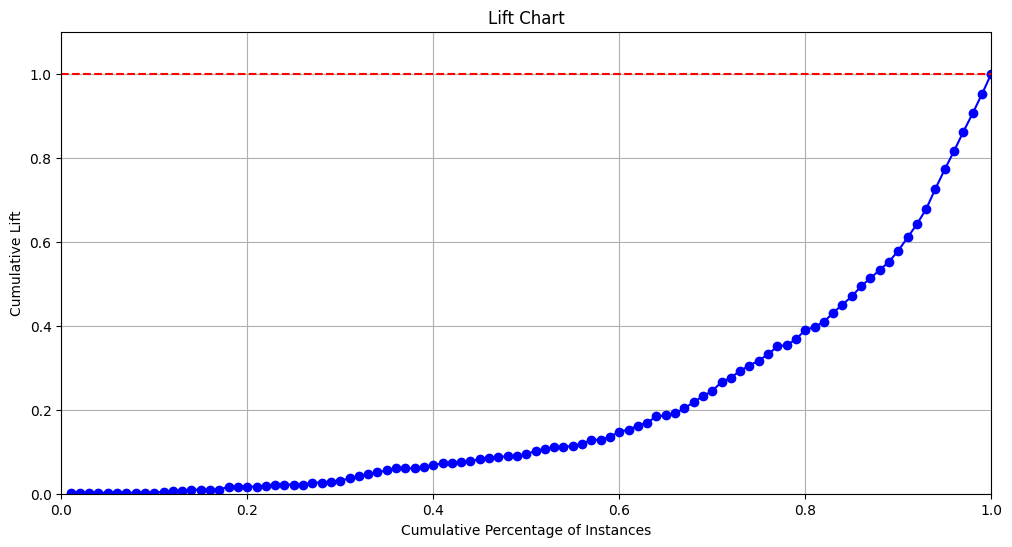

In [ ]:
plt.figure(figsize=(12, 6))

# Plot lift values
plt.plot(lift_data['Cumulative_Percentage'], lift_data['Cumulative_Lift'], marker='o', color='blue')
plt.axhline(y=1, color='red', linestyle='--')  # Random guessing line

plt.title('Lift Chart')
plt.xlabel('Cumulative Percentage of Instances')
plt.ylabel('Cumulative Lift')
plt.xlim([0, lift_data['Cumulative_Percentage'].max()])
plt.ylim([0, lift_data['Cumulative_Lift'].max() * 1.1])
plt.grid()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

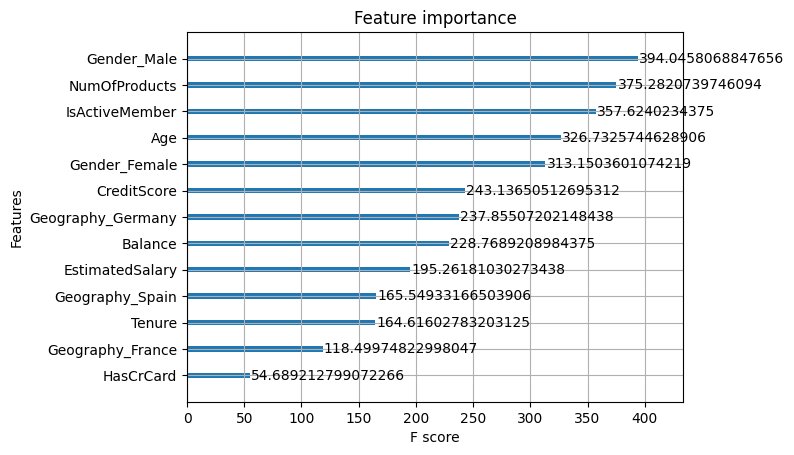

In [ ]:
xgb.plot_importance(best_model,importance_type='cover')
# xgb.plot_importance(best_model,importance_type='weight')
# xgb.plot_importance(best_model,importance_type='total_gain')

#Balance dataset


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(X_train, y_train)

In [ ]:
print(
    f"The distribution of labels in train data is: \n {pd.value_counts(y_train)}\nPercentage distribution: \n {pd.value_counts(y_train, normalize=True)}")
print(
    f"The distribution of labels in train data is after SMOTE: \n {pd.value_counts(y_oversample)}\nPercentage distribution: \n {pd.value_counts(y_oversample, normalize=True)}")

The distribution of labels in train data is: 
 Exited
0    4769
1    1231
Name: count, dtype: int64
Percentage distribution: 
 Exited
0    0.794833
1    0.205167
Name: proportion, dtype: float64
The distribution of labels in train data is after SMOTE: 
 Exited
0    4769
1    4769
Name: count, dtype: int64
Percentage distribution: 
 Exited
0    0.5
1    0.5
Name: proportion, dtype: float64


<ipython-input-41-30901455749f>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  f"The distribution of labels in train data is: \n {pd.value_counts(y_train)}\nPercentage distribution: \n {pd.value_counts(y_train, normalize=True)}")
<ipython-input-41-30901455749f>:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  f"The distribution of labels in train data is after SMOTE: \n {pd.value_counts(y_oversample)}\nPercentage distribution: \n {pd.value_counts(y_oversample, normalize=True)}")


In [ ]:
results_oversampled = {}

# iterate over classifiers
for name, clf in zip(names, classifiers):
    classifier_result = {}
    print(f"CLASSIFIER: {name}")
    clf.fit(X_oversample, y_oversample)
    y_pred = clf.predict(X_test)
    print(f'Classification report: {classification_report(y_test, y_pred)}')
    classifier_result['f1_1'] = f1_score(y_test, y_pred, pos_label=1, average='binary')
    classifier_result['f1_0'] = f1_score(y_test, y_pred, pos_label=0, average='binary')
    classifier_result['AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    classifier_result['precision_1'] = precision_score(y_test, y_pred, pos_label=1, average='binary')
    classifier_result['precision_0'] = precision_score(y_test, y_pred, pos_label=0, average='binary')
    results_oversampled[name] = classifier_result

CLASSIFIER: LogisticRegression
Classification report:               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1607
           1       0.38      0.72      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.74      2000

CLASSIFIER: Nearest Neighbors
Classification report:               precision    recall  f1-score   support

           0       0.88      0.76      0.82      1607
           1       0.38      0.59      0.46       393

    accuracy                           0.73      2000
   macro avg       0.63      0.68      0.64      2000
weighted avg       0.79      0.73      0.75      2000

CLASSIFIER: Decision Tree
Classification report:               precision    recall  f1-score   support

           0       0.91      0.85      0.88      1607
           1       0.52      0.66      0.58       393

    accuracy              

In [ ]:
df_results_oversampled = pd.DataFrame(results_oversampled).T.reset_index()
df_results_oversampled

,index,f1_1,f1_0,AUC,precision_1,precision_0
0,LogisticRegression,0.498674,0.802370,0.779015,0.382114,0.912044
1,Nearest Neighbors,0.463682,0.820033,0.708997,0.380719,0.884726
2,Decision Tree,0.582589,0.879510,0.826973,0.518887,0.911824
3,Random Forest,0.509294,0.819425,0.786525,0.401171,0.909643
4,GradientBoost,0.608696,0.890595,0.862613,0.553015,0.916392
